In [ ]:
!wget https://www.dropbox.com/s/hm1bg20k4z2hatw/datasets.zip

In [ ]:
!unzip datasets.zip -d .

In [ ]:
!pip install -r helpers/requirements_colab.txt

In [164]:
# Setup and instantiate the network model
import torch
from torch import nn
from torch.autograd import Variable
import os
from helpers import dataset as ds
from helpers import datapreparation as dp
import numpy as np
import time

class Generalist(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super(Generalist, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.5)
        #self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        #self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.notes_decoder = nn.Linear(in_features=hidden_size, out_features=input_size)
        self.out1 = nn.ReLU()
        self.out2 = nn.Sigmoid()
        self.hidden = self.init_hidden()

    def init_hidden(self, tag=None):
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).cuda(),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).cuda())

    def forward(self, input_sequence, tag=None):
        output, self.hidden = self.rnn(input_sequence, self.hidden)
        #output = self.out1(output)
        output = self.notes_decoder(output)
        output = self.out2(output)
        return output
    
dirpath = os.path.join('datasets', 'training', 'piano_roll_fs5')
X = ds.pianoroll_dataset_batch(dirpath)
input_size = X[0][0].size()[-1]
hidden_size = 256
num_layers = 2
batch_size = 1

model = Generalist(input_size, hidden_size, num_layers, batch_size).cuda()

In [165]:
# Instantiate hyperparameters
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

#loss_func = nn.L1Loss() 
#loss_func = nn.BCELoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.1) 
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1e-2)

#for song_x, tag, song_y in X:
  #print(len(song_x), len(song_y))
  #print((song_x[-1] - song_y[-2]).squeeze(1).cpu().data.numpy().sum())

In [166]:
with torch.no_grad():
    output = model(X[0][0].cuda())
    print(output[42])

epochs = 16
chunk_size = 32
chunk_overlap = 4
start = time.time()

for epoch in range(epochs):
    sum_loss = 0
    chunk_count = 0
    for input_sequence, tag, target_sequence in X:
        i = 0
        length = len(input_sequence)
        while i < length:
          j = min(i+chunk_size, length)
          input_seq = input_sequence[i:j]
          target_seq = target_sequence[i:j]
          # Step 1. Remember that Pytorch accumulates gradients.
          # We need to clear them out before each instance
          model.zero_grad()
          optimizer.zero_grad()

          # Also, we need to clear out the hidden state of the LSTM,
          # detaching it from its history on the last instance.
          model.hidden = model.init_hidden()

          # Step 3. Run our forward pass.
          pred_seq = model(input_seq.cuda())

          # Step 4. Compute the loss, gradients, and update the parameters by
          #  calling optimizer.step()
          loss = loss_func(pred_seq, target_seq.cuda())
          loss.backward()
          optimizer.step()
        
          sum_loss += loss
          chunk_count += 1
          i += chunk_size-chunk_overlap
    
    print('loss: ' + str(sum_loss/(chunk_count)))
    print(str(epoch+1) + '/' + str(epochs))
    
print("runtime: ", time.time() - start)

with torch.no_grad():
    output = model(X[0][0].cuda())
    print(output[42])
    print(X[0][-1][42] > 0)

tensor([[0.4985, 0.4919, 0.4886, 0.4919, 0.4924, 0.4944, 0.4892, 0.5089, 0.4910,
         0.5196, 0.4862, 0.5095, 0.5019, 0.5161, 0.4870, 0.4941, 0.4960, 0.5003,
         0.5070, 0.5114, 0.4879, 0.4925, 0.5055, 0.5073, 0.5139, 0.4927, 0.4891,
         0.4987, 0.5030, 0.5059, 0.4898, 0.5178, 0.5045, 0.4912, 0.4876, 0.4882,
         0.5070, 0.5011, 0.5130, 0.5091, 0.5148, 0.5168, 0.5095, 0.5085, 0.5163,
         0.5024, 0.5095, 0.5094, 0.4957, 0.5119, 0.4881, 0.4967, 0.4987, 0.4923,
         0.5124, 0.4917, 0.5034, 0.5030, 0.4961, 0.4973, 0.4951, 0.5055, 0.5023,
         0.4977, 0.4906, 0.4853, 0.4951, 0.5016, 0.4885, 0.4947, 0.4829, 0.4870,
         0.4861, 0.4955, 0.5072, 0.4939, 0.4998, 0.4834, 0.4836, 0.5137, 0.5114,
         0.5082, 0.4926, 0.4960, 0.5055, 0.4906, 0.5003, 0.5123, 0.5140, 0.5148,
         0.4880, 0.5211, 0.5013, 0.4929, 0.4978, 0.4895, 0.4916, 0.4960, 0.5097,
         0.4961, 0.4948, 0.4946, 0.4964, 0.5148, 0.5143, 0.4991, 0.4894, 0.4897,
         0.5042, 0.4943, 0.5

In [ ]:
with torch.no_grad():
    output = model(X[0][0].cuda())
    print(output[42])

epochs = 200
start = time.time()

for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    sum_loss = 0
    for input_sequence, tag, target_sequence in X:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 3. Run our forward pass.
        pred_sequence = model(input_sequence.cuda())

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_func(pred_sequence, target_sequence.cuda())
        sum_loss += loss
        loss.backward()
        optimizer.step()
    
    print('loss: ' + str(sum_loss/len(X)))
    print(str(epoch+1) + '/' + str(epochs))
    
print("runtime: ", time.time() - start)

with torch.no_grad():
    output = model(X[0][0].cuda())
    print(output[42])
    print(X[0][-1][42] > 0)

In [171]:
torch.save(model.state_dict(), 'GenState256_256_1l')

In [77]:
model.load_state_dict(torch.load('GenState256'))

RuntimeError: Error(s) in loading state_dict for Generalist:
	Missing key(s) in state_dict: "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0", "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 
	Unexpected key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". 

In [ ]:
def test(model, song):
    prediction = []
    notes_dim = song.size()[-1]
    x = torch.ones(1, 1, notes_dim).cuda()
    y = torch.zeros(1, 1, notes_dim).cuda()
    with torch.no_grad():
        model.init_hidden()
        for i in range(song.size()[0]):
            notes = song[i].view(1, 1, notes_dim)
            output = model(notes.cuda())
            output = torch.where(output > 0.1, x, y)
            prediction.append(output[0].squeeze(0).cpu().data.numpy())
    
    return np.array(prediction).T

prediction = test(model, X[42][0])
dp.visualize_piano_roll(prediction)

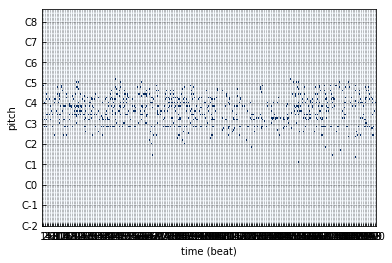

In [148]:
with torch.no_grad():
    model.init_hidden()
    output = model(X[42][0].cuda())

prediction = output.squeeze(1).cpu().data.numpy().T
#prediction = np.array([np.pad(row, (22, 22), 'constant', constant_values=0) for row in prediction])
prediction /= prediction.max()
prediction = prediction > 0.1
dp.visualize_piano_roll(prediction)

In [ ]:
dp.embed_play_v1(prediction)

In [ ]:
original = X[42][0].squeeze(1).cpu().data.numpy().T
#song = np.array([np.pad(row, (22, 22), 'constant', constant_values=0) for row in original])
dp.visualize_piano_roll(original)

In [ ]:
dp.embed_play_v1(original)

In [ ]:
dp.gen_music_seconds_smooth(model, X[42][0].cuda())

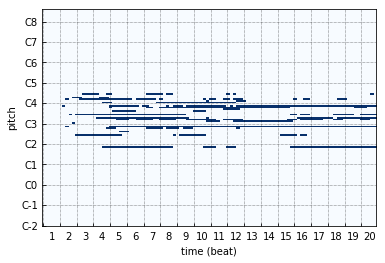

In [170]:
def compose(model, init_song, init_len, max_len):
    composition = []
    notes_dim = init_song.size()[-1]
    with torch.no_grad():
        model.init_hidden()
        for i in range(max_len):
            if i < init_len:
                notes = init_song[i].view(1, 1, notes_dim)
            else:
                notes = torch.ge(output, 0.1).float() #/torch.max(output)

            composition.append(notes[0].squeeze(0).cpu().data.numpy())
            output = model(notes.cuda())

    return np.array(composition).T

composition = compose(model, X[42][0], 10, 100)
dp.visualize_piano_roll(composition)
dp.embed_play_v1(composition)